<a href="https://colab.research.google.com/github/afaqahmed91/machinelearning/blob/main/tanzania_water_pump/TanzaniaWaterPump_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install feature-engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.1/364.1 kB 7.1 MB/s eta 0:00:00


## Preprocessing Data

In [ ]:
import xgboost as xgb
from matplotlib import pyplot as plt
from feature_engine import encoding, imputation
from sklearn import base, pipeline
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
# visualize XGBoost
from yellowbrick import classifier


In [ ]:
def distance(df: pd.DataFrame, lat: float, lon: float) -> float:
    p = 0.017453292519943295
    lat_diff = (df["latitude"] - lat) * p
    lon_diff = (df["longitude"] - lon) * p
    hav = (
        0.5
        - np.cos(lat_diff) / 2
        + np.cos(lat * p) * np.cos(df["latitude"] * p) * (1 - np.cos(lon_diff)) / 2
    )
    return 12742 * np.arcsin(np.sqrt(hav))


def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess the input DataFrame by imputing missing values, creating new features,
    and dropping unnecessary columns.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing raw data.

    Returns:
    pd.DataFrame: The preprocessed DataFrame with imputed values, new features,
                  and selected columns.

    Imputations and Transformations:
    - longitude: Impute missing values (0) based on the mean longitude of the region code.
    - gps_height: Impute missing values (0) based on the mean gps_height of the basin.
    - center_distance: Calculate the distance from a central point (-6.5, 37.5).
    - population: Impute missing values (0 or 1) based on the mean population of the basin.
    - age: Calculate the age of the water point based on the recorded date and construction year.
    - quantity: Replace 'unknown' with 'dry' and convert to categorical type.
    - public_meeting: Fill missing values with False and convert to integer type.
    - permit: Fill missing values with False and convert to integer type.
    - funder: Fill missing values with 'Unknown', keep top 10 funders, and convert to categorical type.
    - installer: Fill missing values with 'Unknown', replace '0' with 'Unknown', keep top 10 installers, and convert to categorical type.
    - ground_water: Replace 'groundwater' with 1, 'surface' with 0, 'unknown' with 1, and convert to integer type.
    - age: Recalculate age, replacing negative or NaN values with the mean age.

    Dropped Columns:
    - region_code, date_recorded, construction_year, water_quality, extraction_type,
      payment, scheme_management, waterpoint_type_group, scheme_name, amount_tsh,
      subvillage, num_private, district_code, recorded_by, wpt_name, ward,
      quantity_group, source_class, source_type, latitude, longitude.
    """
    return (
            df.assign(
            # imputed longitude based on region code
            longitude=np.where(
                df["longitude"] == 0,
                df["region_code"].map(
                    df.groupby("region_code")["longitude"].mean().to_dict()
                ),
                df["longitude"],
            ),
            # imputed longitude based on basin
            gps_height=np.where(
                df["gps_height"] == 0,
                df["basin"].map(df.groupby("basin")["gps_height"].mean().to_dict()),
                df["gps_height"],
            ),
            center_distance=lambda x: distance(x, -6.5, 37.5),
            population=np.where(
                (df["population"] == 0) | (df["population"] == 1),
                df["basin"].map(
                    df.groupby("basin")["population"].mean().astype(int).to_dict()
                ),
                df["population"],
            ),
            age=(
                df["date_recorded"].str.split("-").str[0].astype(int)
                - df["construction_year"].replace(0, np.nan)
            ),
            quantity=df.quantity.replace({"unknown": "dry"})
            # .replace({"dry": 1, "insufficient": 2, "seasonal": 3, "enough": 4})
            .astype("category"),
            public_meeting=df.public_meeting.fillna(False).astype(int),
            permit=df.permit.fillna(False).astype(int),
            funder=df.funder.fillna("Unknown").pipe(topn, n=10).astype("category"),
            installer=df.installer.fillna("Unknown")
            .replace({"0": "Unknown"})
            .pipe(topn, n=10)
            .astype("category"),
            ground_water=df.source_class.replace(
                {"groundwater": 1, "surface": 0, "unknown": 1}
            ).astype(int),
        )
        .assign(
            age=lambda _df: np.where(
                (_df["age"] < 0) | (_df["age"].isna()), _df["age"].mean(), _df["age"]
            )
        )
        .drop(
            columns=[
                "region_code",
                "date_recorded",
                "construction_year",
                "latitude",
                "longitude",
                "water_quality",
                "extraction_type",
                "payment",
                "scheme_management",
                "waterpoint_type_group",
                "scheme_name",
                "amount_tsh",
                "subvillage",
                "num_private",
                'district_code',
                "recorded_by",
                "wpt_name",
                "ward",
                "quantity_group",
                "source_class",
                "source_type",

            ]
        )
    )


def topn(ser: pd.Series, n: int = 5, default: str = "other"):
    """
    Replace values in a pandas Series with 'default' if they are not among the top 'n' most frequent values.

    Parameters:
    ser (pandas.Series): The input pandas Series.
    n (int, optional): The number of top most frequent values to keep. Defaults to 5.
    default (str, optional): The value to replace non-top 'n' values with. Defaults to "other".

    Returns:
    pandas.Series: A pandas Series with non-top 'n' values replaced by 'default'.
    """
    counts = ser.value_counts()
    return ser.where(ser.isin(counts.index[:n]), default)

def preprocess_y(df):
    return (
        df["status_group"].replace({"functional": 2, "non functional": 0, "functional needs repair": 1}).values
    )




In [ ]:
raw_x = pd.read_csv("https://raw.githubusercontent.com/afaqahmed91/machinelearning/refs/heads/main/tanzania_water_pump/data/training_set_values.csv", index_col = "id")
raw_y = pd.read_csv("https://raw.githubusercontent.com/afaqahmed91/machinelearning/refs/heads/main/tanzania_water_pump/data/training_set_labels.csv", index_col = "id")

In [ ]:
raw_x.basin.value_counts()

,count
basin,
Lake Victoria,10248
Pangani,8940
Rufiji,7976
Internal,7785
Lake Tanganyika,6432
Wami / Ruvu,5987
Lake Nyasa,5085
Ruvuma / Southern Coast,4493
Lake Rukwa,2454


In [ ]:
processed_x = preprocess_data(raw_x)
processed_y = preprocess_y(raw_y)

<ipython-input-3-a2d0934238a7>:63: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  quantity=df.quantity.replace({"unknown": "dry"}).replace(
<ipython-input-3-a2d0934238a7>:66: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  public_meeting=df.public_meeting.fillna(False).astype(int),
<ipython-input-3-a2d0934238a7>:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.

In [ ]:
pump_X_train, pump_X_test, y_train, y_test = train_test_split(
    processed_x, processed_y, random_state=40, train_size=0.75, stratify=processed_y
)

## One-hot Encoding all categorical variable

In [ ]:
cate_vars = ['funder',  'installer', 'basin', 'region',
      'lga',
        'extraction_type_group',
       'extraction_type_class', 'management', 'management_group',
       'payment_type', 'quality_group', 'quantity', 'source',
       'waterpoint_type',
       ]

encoder = encoding.OneHotEncoder(top_categories=10, drop_last=True, variables=cate_vars)

In [ ]:
encoder.fit(pump_X_train)
X_train = encoder.transform(pump_X_train)
X_test = encoder.transform(pump_X_test)



In [ ]:
# out of the box
xg_oob = xgb.XGBClassifier()
xg_oob.fit(X_train, y_train)
xg_oob.score(X_test, y_test)

0.7925925925925926

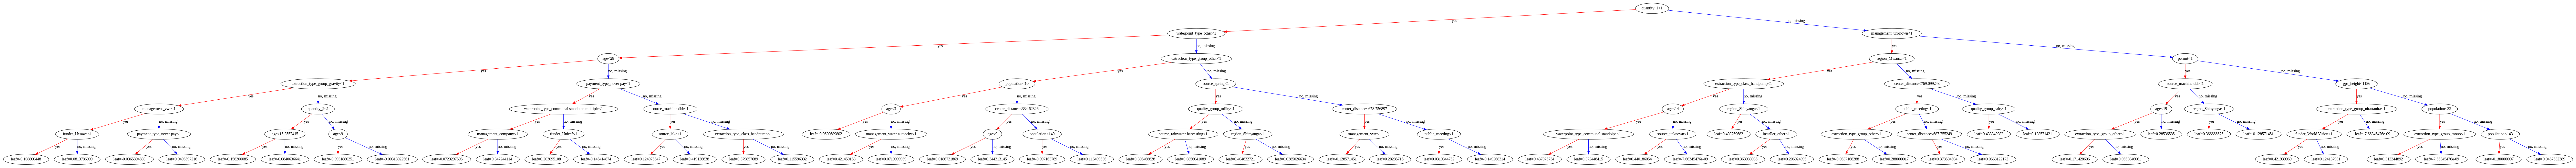

In [ ]:

xgb.plot_tree(xg_oob, num_trees=0)
fig = plt.gcf()
fig.set_size_inches(150, 100)

In [ ]:
pd.DataFrame(X_test.iloc[2500]).T

,gps_height,population,public_meeting,permit,center_distance,age,ground_water,funder_other,funder_Government Of Tanzania,funder_Unknown,...,source_dam,source_other,source_unknown,waterpoint_type_communal standpipe,waterpoint_type_hand pump,waterpoint_type_other,waterpoint_type_communal standpipe multiple,waterpoint_type_improved spring,waterpoint_type_cattle trough,waterpoint_type_dam
18975,3.0,50.0,1.0,1.0,164.36231,28.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
xg_oob.predict_proba(pd.DataFrame(X_test.iloc[2500]).T)

array([[0.4178805 , 0.00498083, 0.57713866]], dtype=float32)

In [ ]:
xg_oob.predict(pd.DataFrame(X_test.iloc[2500]).T)

array([2])

In [ ]:
xg = xgb.XGBClassifier(early_stopping_rounds=20)
xg.fit(X_train, y_train, eval_set =[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-mlogloss:0.92968	validation_1-mlogloss:0.93378
[1]	validation_0-mlogloss:0.82881	validation_1-mlogloss:0.83542
[2]	validation_0-mlogloss:0.76308	validation_1-mlogloss:0.77185
[3]	validation_0-mlogloss:0.71637	validation_1-mlogloss:0.72714
[4]	validation_0-mlogloss:0.68318	validation_1-mlogloss:0.69525
[5]	validation_0-mlogloss:0.65933	validation_1-mlogloss:0.67288
[6]	validation_0-mlogloss:0.64077	validation_1-mlogloss:0.65573
[7]	validation_0-mlogloss:0.62253	validation_1-mlogloss:0.63926
[8]	validation_0-mlogloss:0.60848	validation_1-mlogloss:0.62695
[9]	validation_0-mlogloss:0.59922	validation_1-mlogloss:0.61884
[10]	validation_0-mlogloss:0.59090	validation_1-mlogloss:0.61172
[11]	validation_0-mlogloss:0.58375	validation_1-mlogloss:0.60547
[12]	validation_0-mlogloss:0.57721	validation_1-mlogloss:0.60006
[13]	validation_0-mlogloss:0.57183	validation_1-mlogloss:0.59596
[14]	validation_0-mlogloss:0.56619	validation_1-mlogloss:0.59189
[15]	validation_0-mlogloss:0.56057	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
xg.score(X_test, y_test)

0.7925925925925926

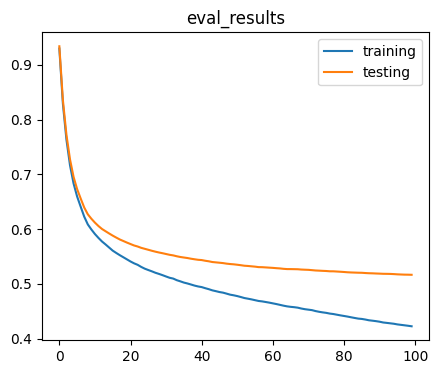

In [ ]:
results = xg.evals_result()
fig, ax = plt.subplots(figsize=(8, 4))
ax = (pd.DataFrame({'training': results['validation_0']['mlogloss'],
'testing': results['validation_1']['mlogloss']})
.plot(figsize=(5,4), ax=ax,
title='eval_results')
)

In [ ]:
xg.get_params()

{'objective': 'multi:softprob',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': 20,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, pyll
from hyperopt.early_stop import no_progress_loss
from typing import Dict, Union
from sklearn.metrics import accuracy_score

## Hyperparameter Optimization *XGBoost* Usin hyperopt optimiztion
⚠️ Optimization take approx 3 hours to run ⚠️

In [ ]:

xg = xgb.XGBClassifier(eval_metric = "logloss", early_stopping_rounds=20)

space = {
    'max_depth': hp.quniform('max_depth', 1, 10, 1), # tree
    'min_child_weight': hp.loguniform('min_child_weight',-2, 3),
    'gamma': hp.loguniform('gamma', -10, 10), # regularization
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),
    'reg_lambda': hp.uniform('reg_lambda', 1, 10),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'learning_rate': hp.loguniform('learning_rate',-7, 0),
    'n_estimators': hp.quniform('n_estimators', 60, 140, 20)
}

def objective(space: Dict[str, Union[int, float]],
                          X_train: pd.DataFrame, y_train: pd.Series,
                          X_test: pd.DataFrame, y_test: pd.Series):
    params = {
        'max_depth': int(space['max_depth']),
        'min_child_weight': space['min_child_weight'],
        'gamma': space['gamma'],
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'n_estimators': int(space['n_estimators']),
        'objective': 'reg:squarederror',
        'early_stopping_rounds': 50,
        # 'device': 'cuda',  # Enables GPU
        # "tree_method": "hist"
    }
    print(params)
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train, eval_set =[(X_train, y_train), (X_test, y_test)], verbose=False)
    pred = model.predict(X_test)
    score = accuracy_score(y_test, pred)
    return {'loss': -score, 'status': STATUS_OK,  'model': model}



In [ ]:
best = fmin(
    fn=lambda options: objective(options, X_train, y_train, X_test, y_test),
    space=space,
    algo=tpe.suggest,
    max_evals=1000,
    trials = Trials(),
)

{'max_depth': 2, 'min_child_weight': 1.253589057450236, 'gamma': 5.906309872188587, 'reg_alpha': 4.425284366308809, 'reg_lambda': 7.891437774776464, 'colsample_bytree': 0.7410597749857233, 'learning_rate': 0.0013763008942076671, 'n_estimators': 120, 'objective': 'reg:squarederror', 'early_stopping_rounds': 50}
{'max_depth': 1, 'min_child_weight': 0.9881371536529601, 'gamma': 6.790441037247459e-05, 'reg_alpha': 4.264088071374187, 'reg_lambda': 6.789823769594102, 'colsample_bytree': 0.6551706900476507, 'learning_rate': 0.02187568962735012, 'n_estimators': 120, 'objective': 'reg:squarederror', 'early_stopping_rounds': 50}
{'max_depth': 3, 'min_child_weight': 12.385397175104522, 'gamma': 0.0010456652868177825, 'reg_alpha': 6.8873288303325815, 'reg_lambda': 1.5847703464863168, 'colsample_bytree': 0.5468806032483753, 'learning_rate': 0.017075666204398286, 'n_estimators': 120, 'objective': 'reg:squarederror', 'early_stopping_rounds': 50}
{'max_depth': 2, 'min_child_weight': 0.2459469274350929

In [ ]:
best

{'colsample_bytree': 0.6845190872400219,
 'gamma': 0.00015134997125550298,
 'learning_rate': 0.2811249289798885,
 'max_depth': 10.0,
 'min_child_weight': 3.0013641552671086,
 'n_estimators': 140.0,
 'reg_alpha': 2.785023256829874,
 'reg_lambda': 2.5171586184420396}

# Run Best Model

In [ ]:
best_params = {'colsample_bytree': 0.6845190872400219,
 'gamma': 0.00015134997125550298,
 'learning_rate': 0.2811249289798885,
 'max_depth': int(10.0),
 'min_child_weight': 3.0013641552671086,
 'n_estimators': int(140.0),
 'reg_alpha': 2.785023256829874,
 'reg_lambda': 2.5171586184420396,
 'random_state': 42}
model = xgb.XGBClassifier(**best_params)
model.fit(X_train, y_train, eval_set =[(X_train, y_train), (X_test, y_test)], verbose=False)

pred = model.predict(X_test)
score = accuracy_score(y_test, pred)


In [ ]:
{'loss': -score, 'status': STATUS_OK,  'model': model}

{'loss': -0.8044444444444444,
 'status': 'ok',
 'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.6845190872400219, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None,
               gamma=0.00015134997125550298, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.2811249289798885, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=10, max_leaves=None,
               min_child_weight=3.0013641552671086, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=140,
               n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)}

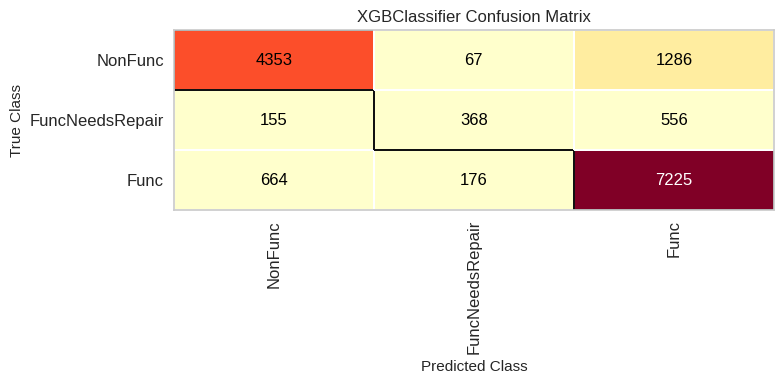

ConfusionMatrix(ax=<Axes: title={'center': 'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=['NonFunc', 'FuncNeedsRepair', 'Func'],
                cmap=<matplotlib.colors.ListedColormap object at 0x7c75f6a18a00>,
                estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_byt...
                                        grow_policy=None, importance_type=None,
                                        interaction_constraints=None,
                                        learning_rate=0.2811249289798885,
                                        max_bin=None, max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=10,
                                        max_leaves=None,
                                        min_child_weight=3.0013641552671086,
                                        missing=nan, monotone_constraints=None,
                                        multi_strategy=None, n_estimators=140,
                                        n_jobs=None, num_parallel_tree=None,
                                        objective='multi:softprob', ...))

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
classifier.confusion_matrix(model, X_train, y_train,
X_test, y_test,
classes=['NonFunc', 'FuncNeedsRepair', 'Func'], ax=ax
)

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_curve
)

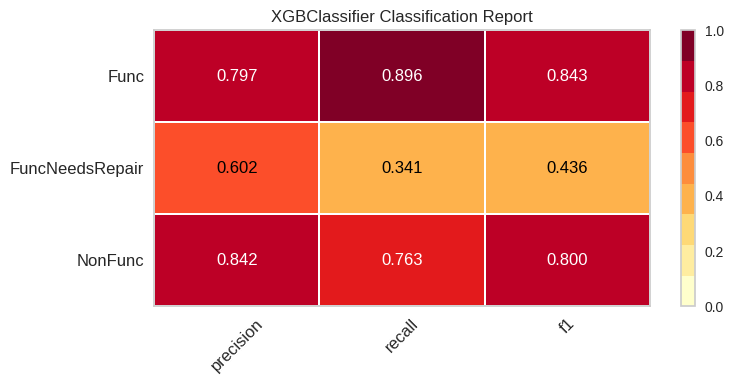

ClassificationReport(ax=<Axes: title={'center': 'XGBClassifier Classification Report'}>,
                     classes=['NonFunc', 'FuncNeedsRepair', 'Func'],
                     cmap=<matplotlib.colors.ListedColormap object at 0x7c75f7459930>,
                     estimator=XGBClassifier(base_score=None, booster=None,
                                             callbacks=None,
                                             colsample_bylevel=None,
                                             colsample_bynode=None,
                                             colsample_bytree=0.6845190872400219,
                                             device=Non...
                                             importance_type=None,
                                             interaction_constraints=None,
                                             learning_rate=0.2811249289798885,
                                             max_bin=None,
                                             max_cat_threshold=None,
                                             max_cat_to_onehot=None,
                                             max_delta_step=None, max_depth=10,
                                             max_leaves=None,
                                             min_child_weight=3.0013641552671086,
                                             missing=nan,
                                             monotone_constraints=None,
                                             multi_strategy=None,
                                             n_estimators=140, n_jobs=None,
                                             num_parallel_tree=None,
                                             objective='multi:softprob', ...))

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
classifier.classification_report(model, X_train, y_train,
X_test, y_test, classes=['NonFunc', 'FuncNeedsRepair', 'Func'],
micro=False, macro=False, ax=ax)

# Analysis
For detecting non functional it is necessary that the model has high recall

In [ ]:
from sklearn.metrics import (
    roc_curve,
    auc, RocCurveDisplay
)
from sklearn.preprocessing import label_binarize

In [ ]:
y_pred_proba = model.predict_proba(X_test)

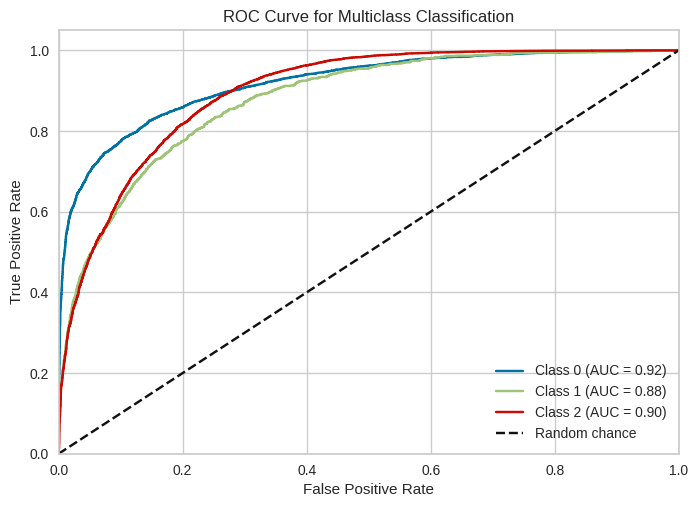

In [ ]:
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])


# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# # Compute micro-average ROC curve and AUC
# fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# plt.plot(fpr["micro"], tpr["micro"], linestyle='--', label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc='lower right')
plt.show()

# Testing on submission data

In [ ]:
raw_test = pd.read_csv("https://raw.githubusercontent.com/afaqahmed91/machinelearning/refs/heads/main/tanzania_water_pump/data/test_set_values.csv", index_col = "id")

In [ ]:
processed_test = preprocess_data(raw_test)

<ipython-input-3-a2d0934238a7>:63: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  quantity=df.quantity.replace({"unknown": "dry"}).replace(
<ipython-input-3-a2d0934238a7>:66: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  public_meeting=df.public_meeting.fillna(False).astype(int),
<ipython-input-3-a2d0934238a7>:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.

In [ ]:
test_data = encoder.transform(processed_test)

In [ ]:
label_predictions = model.predict(test_data)

In [ ]:
raw_test["status_group"] = pd.Series(label_predictions).map({2: "functional", 0: "non functional",1:"functional needs repair"}).values

In [ ]:
raw_test["status_group"].to_csv("submission.csv")

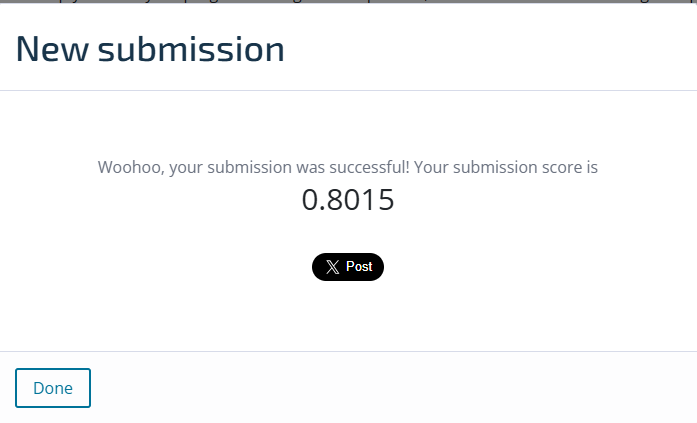

In [ ]:
raw_x["status_group"]= raw_y["status_group"]

In [ ]:
pd.concat([raw_x, raw_test], axis=0).to_csv("combined_data.csv")